# 0 Imports

In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
import torch
import numpy as np

# 1 Dataset and Dataloader

In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import pandas as pd
from pathlib import Path

class ImageCaptionDataset(Dataset):
    def __init__(self, image_folder, captions_file, processor):

        self.image_folder = image_folder
        self.processor = processor

        root_img, root_cpt = Path(image_folder), Path(captions_file)
        if not (root_img.exists() and root_img.is_dir()):
            raise ValueError(f"Data root '{root_img}' is invalid")
        
        if not (root_cpt.exists() and root_cpt.is_file()):
            raise ValueError(f"Data root '{root_cpt}' is invalid")

        self.df = pd.read_table(captions_file, sep=",", header=None, names=["image", "caption"], dtype='str')
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        img_name = os.path.join(self.image_folder, self.df.iloc[idx, 0])
        image = Image.open(img_name)
        caption = self.df.iloc[idx, 1]
        
        encoding = self.processor(images=image, text=caption, padding="max_length", return_tensors="pt").to(device)
        encoding = {k: v.squeeze() for k,v in encoding.items()}

        return encoding

In [67]:
IMG_SIZE = 224

processor = AutoProcessor.from_pretrained("microsoft/git-base")
# train_dataset = ImageCaptionDataset("../data/val_small", "../data/val_small/small_captions_val.txt", processor)
train_dataset = ImageCaptionDataset("../data/train", "../data/train/captions_train.txt", processor)

item = train_dataset[0]
for k,v in item.items():
	print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [4]:
BATCH_SIZE = 2

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)
processor.decode(batch["input_ids"][0])

input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


'[CLS] a boy plays ball on a grassy field. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

# 2 Model definition

In [5]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base").to(device)

cuda


# 2.1 initial loss

In [6]:
outputs = model(
    input_ids=batch["input_ids"],
	attention_mask=batch["attention_mask"],
	pixel_values=batch["pixel_values"],
	labels=batch["input_ids"]
)
outputs.loss

/home/white/miniconda3/envs/dml/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,


tensor(12.1147, device='cuda:0', grad_fn=<NllLossBackward0>)

# 3 Training 

In [7]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
num_epoch = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

train_loss = []
for epoch in range(num_epoch):
	for idx, batch in enumerate(train_dataloader):
		torch.cuda.empty_cache()
		input_ids = batch.pop("input_ids").to(device)
		pixel_values = batch.pop("pixel_values").to(device)
		attention_mask = batch.pop("attention_mask").to(device)

		outputs = model(input_ids=input_ids, pixel_values=pixel_values,labels=input_ids, attention_mask=attention_mask)
		
		loss = outputs.loss
		if (idx+1) % 10 == 0: 
			print(f"Epoch [{epoch+1}/{num_epoch}] - step [{idx+1}/{len(train_dataloader)}] - Loss: {loss.item():.4f}")
			train_loss.append(loss.item())

		loss.backward()

		optimizer.step()
		optimizer.zero_grad()

Epoch [1/3] - step [10/1113] - Loss: 8.5455
Epoch [1/3] - step [20/1113] - Loss: 7.4808
Epoch [1/3] - step [30/1113] - Loss: 6.4121
Epoch [1/3] - step [40/1113] - Loss: 5.3208
Epoch [1/3] - step [50/1113] - Loss: 4.1953
Epoch [1/3] - step [60/1113] - Loss: 3.0810
Epoch [1/3] - step [70/1113] - Loss: 2.0347
Epoch [1/3] - step [80/1113] - Loss: 1.2197
Epoch [1/3] - step [90/1113] - Loss: 0.6279
Epoch [1/3] - step [100/1113] - Loss: 0.3697
Epoch [1/3] - step [110/1113] - Loss: 0.3429
Epoch [1/3] - step [120/1113] - Loss: 0.2926
Epoch [1/3] - step [130/1113] - Loss: 0.2470
Epoch [1/3] - step [140/1113] - Loss: 0.1536
Epoch [1/3] - step [150/1113] - Loss: 0.1965
Epoch [1/3] - step [160/1113] - Loss: 0.1428
Epoch [1/3] - step [170/1113] - Loss: 0.0991
Epoch [1/3] - step [180/1113] - Loss: 0.1678
Epoch [1/3] - step [190/1113] - Loss: 0.1219
Epoch [1/3] - step [200/1113] - Loss: 0.1187
Epoch [1/3] - step [210/1113] - Loss: 0.0900
Epoch [1/3] - step [220/1113] - Loss: 0.1206
Epoch [1/3] - step 

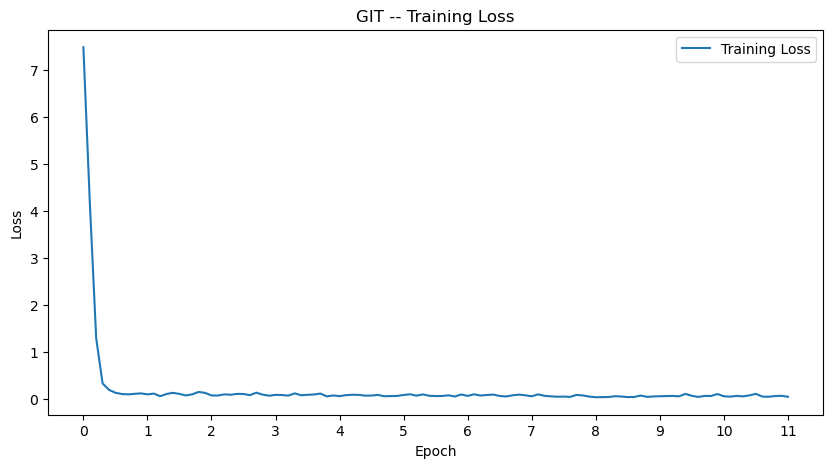

In [13]:
import matplotlib.pyplot as plt

def mean(l): return sum(l)/len(l)

lt = len(train_loss)
step = 100
t_l = [mean(train_loss[i:min(i+lt//step, lt)]) for i in range(0, lt, lt//step)]
plt.figure(figsize=(10,5))
plt.plot(t_l, label='Training Loss')
plt.title('GIT -- Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(ticks=range(0, len(t_l), 10), labels=range(0, 12))
plt.legend()
plt.show()
# plt.savefig('../img/GIT.pdf', format='pdf')

# 4 Caption generation

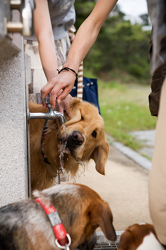

Caption: a group of people are sitting on steps outside of a building.


In [66]:
import random

idx = random.randint(0, len(train_dataset)) 
df = pd.read_table("../data/test/captions_test.txt", sep=",", header=None, names=["image", "caption"], dtype='str')
img_name = os.path.join("../data/test", df.iloc[idx, 0])
image = Image.open(img_name)
width, height = image.size
display(image.resize((int(0.5*width), int(0.5*height))))

# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

# generate caption
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(f"Caption: {generated_caption}")